<a href="https://colab.research.google.com/github/denisecammarota/matbio/blob/master/tp3/P3_Ej3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Práctica 3 - Ejercicio 3**: *Simulación Estocástica*
***Matemática de los Sistemas Biológicos - 2021***

**Alumna**: Denise S. Cammarota

In [ ]:
#@title 
#importo librerías que me van a ser útiles en hacer las simulaciones
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint
plt.style.use('seaborn')

En este ejercicio, consideraremos un sistema poblacional con reproducción y competencia intraespecífica, del tipo:

\begin{align*}
A \xrightarrow{b} A + A  \tag{R1}
\\
A + A \xrightarrow{d} A  \tag{R2}
\end{align*}

donde $b$ y $d$ son tasas asociadas a la reproducción y a la competencia respectivamente. Estas son las dos reacciones posibles en el sistema, a las que llamamos 1 y 2, como indicado en las ecuaciones. 

Por un lado, simularemos la evolución temporal de la población utilizando el algoritmo de Gillespie. Probando diferentes valores de $b,d$ y de condiciones iniciales, observaremos los posibles comportamientos de este sistema. 

Por otra parte, podemos comparar con el comportamiento de la solución macroscópica obtenida a partir del desarrollo de Van Kampen. El ansatz de van Kampfen consiste en proponer que el proceso estocástico $A$ satisface que:

\begin{align*}
A(t) = \Omega \phi(t) + \sqrt{\Omega} \xi(t),
\end{align*}

donde $\Omega$ en este caso corresponde a $N$, que es el tamaño total del sistema, es decir, la cantidad de slots disponibles. 

En este caso, el método de van Kampen  nos dice que el comportamiento de $n(t)$, la proporción de individuos relativa al tamaño del sistema, sigue la siguiente ecuación logística:

\begin{align*}
\dot{\phi} = (2b-d) \phi - 2b {\phi}^{2} = (2b-d)\phi\Big(1 - \frac{\phi}{1 - \frac{d}{2b}}\Big), 
\end{align*}

cuya capacidad de carga es $K = 1-\frac{d}{2b}$ y su tasa de reproducción $r = 2b-d$. Su solución está dada por:

\begin{align*}
\dot{\phi} = (2b-d) \phi - 2b {\phi}^{2} = (2b-d)\phi\Big(1 - \frac{\phi}{1 - \frac{d}{2b}}\Big), 
\end{align*}

Por otra parte, se puede deducir que las fluctuaciones $\xi$ son tales que cumplen:

\begin{align*}
<\xi^{2}>_{t} \xrightarrow[t \to \infty]{} \frac{d}{2b} = \xi_{0}^2,
\end{align*}

de manera que entonces definimos $\xi_0 = \sqrt{\frac{d}{2b}}$.

Para el estudio de sistema, haremos simulaciones con el metodo de Gillespie, el cual estudiamos en la clase teórica. Junto con alrededor de $500$ realizaciones de la dinámica, graficaremos tanto la solución macroscópica como el valor al que tienden las fluctuaciones a medida que $t\rightarrow \infty$. Utilizaremos siempre un tiempo máximo $t=100$ para todas las simulaciones y un tamaño de sistema $\Omega = 100$. 

In [ ]:
#@title 
#función que va a hacer el algoritmo de gillespie y producir los resultado
#en este caso en particular
def simulation_gillespie(b,d,omega,n,tf):
  #b: la tasa b del enunciado
  #d: la tasa d del enunciado
  #n: tamaño inicial de la población
  #tf: tiempo final (llego aca y se corta la simulación)
  #Primer paso a): inicializamos los k_i coeficientes de las reacciones
  k1 = b #reacción 1
  k2 = d #reaccción 2
  #Primer paso b): inicializamos población inicial y tiempo inicial
  x_vec = []
  t_vec = []
  x_vec.append(n)
  t_aux = 0
  t_vec.append(0) 
  i = 0
  #Empezamos con el loop en la cantidad de pasos que hacemos
  while(t_aux < tf and x_vec[i]>0):
    x_aux = np.copy(x_vec[i]) #poblacion auxiliar, la que teniamos despues del paso anterior
    #Segundo paso: calculamos las propensities
    a1 = k1*x_vec[i]*(omega-x_vec[i]) #k1 * x[i] * (omega - x[i])
    a2 = k2*x_vec[i]  #k1 * x[i] 
    ao = a1 + a2
    #Tercer paso: calculamos el Tau de la próxima reacción, y que reacciones ocurren
    #Para ello, necesito dos números reales aleatorios entre 0 y 1, r1 y r2
    r1 = random.random()
    while (r1==0):
      r1 = random.random()
    r2 = random.random()
    #Ahora, con uno de ellos calculo el tiempo tau, como vimos en clase
    tau = (1/ao) * np.log(1/r1)
    #Y ahora qué reacción ocurre
    react = r2*ao
    #Cuarto paso: actualizar la población en cuestión
    if (react <= a1): #si r2*ao es <= a1, ocurre la reacción 1
      x_aux = x_aux + 1
    else: #sino, ocurre la reacción 2 (hay solo dos reacciones)
      x_aux = x_aux - 1
    #Quinto paso: actualizar el tiempo
    t_aux = t_aux + tau
    t_vec.append(t_aux)
    x_vec.append(x_aux) #añadimos lo que resulta de este paso
    i = i + 1
  return x_vec,t_vec


In [ ]:
#@title 
def sol_exacta(t,b,d,omega,phi0):
  b0 = b * omega
  r = 2*b0 - d 
  s = 2*b0
  c0 = s - r/phi0
  phi = r/(s - (s - r/phi0)*np.exp(-r*t))
  sig_asintotico = np.zeros(shape=t.shape)+np.sqrt(d/(2*b0))
  return phi,sig_asintotico

## **Estado estacionario positivo**

Primero, nos piden estudiar condiciones que nos permitan tener un estado estacionario positivo. Para ello, utilizaremos parámetros $b = 0.1$, $d = 0.1$ y $\phi(0) = 0.85$, es decir, que inicialmente hay 85 individuos en el sistema. En el siguiente gráfico, se presentan 500 simulaciones, junto con $\phi(t)$ predicho por la teoría. También, graficamos $\phi(t) + \xi_0$ y $\phi(t)-\xi_{0}$ para tener una idea de la magnitud de las fluctuaciones. La capacidad de carga del sistema es, para estos valores de los parámetros, $K = 0.5$. La tasa de reproducción $r = 0.1$, mayor a cero. 

Observamos que los resultados de las simulaciones son consistentes con lo que se espera de las predicciones teóricas. Para esta condición inicial, tal que $\phi_{0} > K$, la cantidad de individuos supera la capacidad de carga del sistema. Por lo tanto, es esperable que $n(t)$ disminuya, acercándose a $K$ a medida que el tiempo transcurre. 

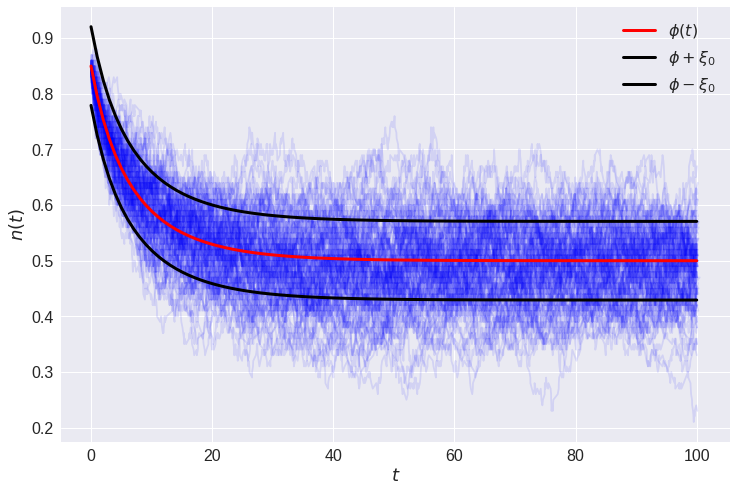

In [ ]:
#@title 
omega = 100
b = 0.1
d = 0.1
b = b/omega
tmax = 100
tf = 100
phi0 = 0.85
t = np.linspace(0,tmax,100)
phi,sig_asintotico = sol_exacta(t,b,d,omega,phi0)
n = int (phi0*omega) #condicion inicial
fig = plt.figure(figsize=(12,8))
for i in range(100):
  x1,t1 = simulation_gillespie(2*b,d,omega,n,tf)
  plt.plot(t1,np.array(x1)/omega,color='b',alpha=0.1)
plt.plot(t,phi,'-r',label='$\phi (t)$',linewidth=3)
plt.plot(t,phi+np.array(sig_asintotico)/np.sqrt(omega),'-k',label=r'$\phi+\xi_{0}$',linewidth=3)
plt.plot(t,phi-np.array(sig_asintotico)/np.sqrt(omega),'-k',label=r'$\phi - \xi_{0}$',linewidth=3)
plt.legend(fontsize=16)
plt.ylabel(r'$n(t)$',fontsize=18)
plt.xlabel(r'$t$',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

En cambio, para la realización del siguiente gráfico, utilizamos una condición inicial $\phi(0) = 0.15$, que es menor a la capacidad de carga. Por lo tanto, como es esperable en promedio, la proporción de individuos en el sistema tiende a aumentar en función del tiempo hasta alcanzar $K$.

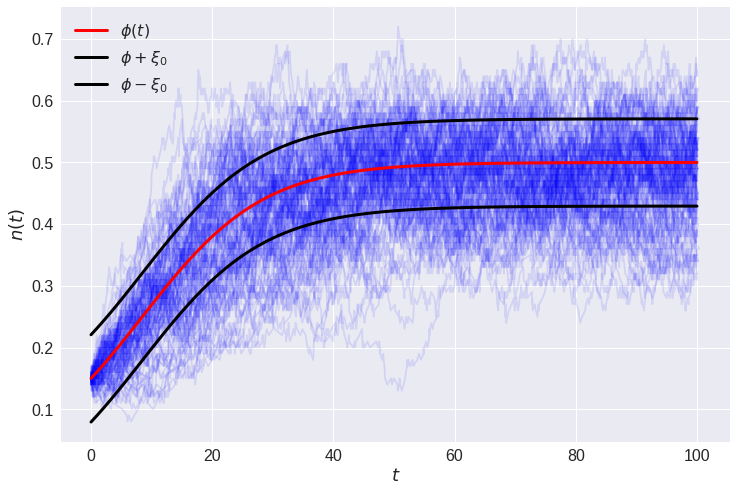

In [ ]:
#@title 
omega = 100
b = 0.1
d = 0.1
b = b/omega
tmax = 100
tf = 100
phi0 = 0.15
t = np.linspace(0,tmax,100)
phi,sig_asintotico = sol_exacta(t,b,d,omega,phi0)
n = int (phi0*omega) #condicion inicial
fig = plt.figure(figsize=(12,8))
for i in range(100):
  x1,t1 = simulation_gillespie(2*b,d,omega,n,tf)
  plt.plot(t1,np.array(x1)/omega,color='b',alpha=0.1)
plt.plot(t,phi,'-r',label='$\phi (t)$',linewidth=3)
plt.plot(t,phi+np.array(sig_asintotico)/np.sqrt(omega),'-k',label=r'$\phi+\xi_{0}$',linewidth=3)
plt.plot(t,phi-np.array(sig_asintotico)/np.sqrt(omega),'-k',label=r'$\phi - \xi_{0}$',linewidth=3)
plt.legend(fontsize=16)
plt.ylabel(r'$n(t)$',fontsize=18)
plt.xlabel(r'$t$',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Finalmente, nos piden quedarnos con una configuración de parámetros que tengamos un estado estacionario positivo. Entonces, debemos calcular la distribución de probabilidad estacionaria $P(x)$ a partir de múltiples realizaciones. Para ello, realizamos 10000 realizaciones, extraemos la parte estacionaria (que aproximadamente se da para $t>60$) y confeccionamos un histograma normalizado con estos valores. Los resultados de este proceso se muestran en el gráfico siguiente, donde también indicamos el valor promedio y las fluctuaciones que vienen de la teoría, junto con estos mismos valores calculados únicamente con los datos de las simulaciones. Observamos que las cantidades teóricas y experimentales son consistentes entre sí. 

In [ ]:
#@title 
real = 10000 #cantidad de realizaciones que voy a hacer para calcular la distribución
real_valores = [] #almaceno valores de realizaciones 
omega = 100
b = 0.1
d = 0.1
b = b/omega
n = int (phi0*omega) #condicion inicial
tf = 100
phi0 = 0.85
for i in range(real):
  x1,t1 = simulation_gillespie(2*b,d,omega,n,tf)
  x1 = np.array(x1)
  t1 = np.array(t1)
  x1 = x1[np.where(t1>60)]
  real_valores.extend(x1)

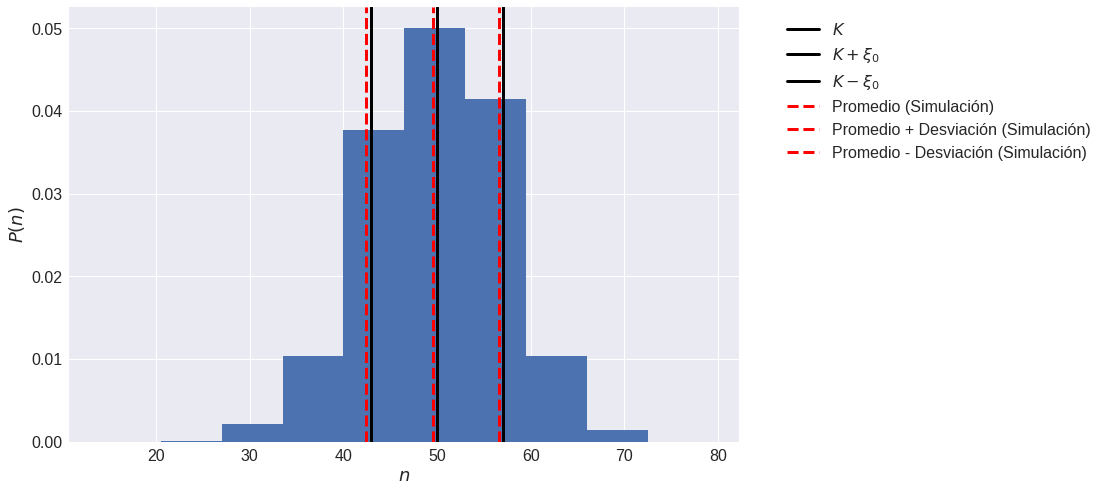

In [ ]:
#@title 
fig = plt.figure(figsize=(12,8))
plt.hist(real_valores,density=True)
plt.xlabel('$n$',fontsize=18)
plt.ylabel('$P(n)$',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
mean_teo = d/(2*b)
std_teo = np.sqrt(d/(2*b))
mean_real = np.mean(np.array(real_valores))
std_real = np.std(np.array(real_valores))
plt.axvline(mean_teo,color='k',label=r'$K$',linewidth=3)
plt.axvline(mean_teo+std_teo,color='k',label=r'$K + \xi_{0}$',linewidth=3)
plt.axvline(mean_teo-std_teo,color='k',label=r'$K - \xi_{0}$',linewidth=3)
plt.axvline(mean_real,color='r',linestyle='--',label=r'Promedio (Simulación)',linewidth=3)
plt.axvline(mean_real+std_real,color='r',linestyle='--',label=r'Promedio + Desviación (Simulación)',linewidth=3)
plt.axvline(mean_real-std_real,color='r',linestyle='--',label=r'Promedio - Desviación (Simulación)',linewidth=3)
plt.legend(fontsize=16,bbox_to_anchor=(1.05, 1))
plt.show()

## **Extinción de la especie**

Por otra parte, el comportamiento del sistema es diferente cuando $b = 0.1$ y $d = 0.4$, resultando en una tasa $r = 0.2 < 0$. En este caso, el sistema tiende a extinguirse, como es esperable para una ecuación logística con tasa de reproducción negativa. Ilustramos esto en el siguiente gráfico, para el cual utilizamos $\phi(0) = 0.1$ como condición inicial. 

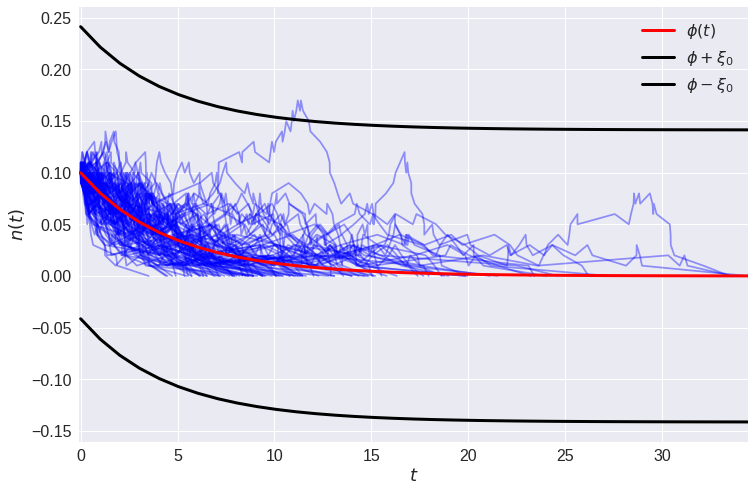

In [ ]:
#@title 
omega = 100
b = 0.1
d = 0.4
b = b/omega
tmax = 100
tf = 100
phi0 = 0.1
tlim_graf = 0
t = np.linspace(0,tmax,100)
phi,sig_asintotico = sol_exacta(t,b,d,omega,phi0)
n = int (phi0*omega) #condicion inicial
fig = plt.figure(figsize=(12,8))
for i in range(100):
  x1,t1 = simulation_gillespie(2*b,d,omega,n,tf)
  tlim_graf = max(tlim_graf,max(t1))
  plt.plot(t1,np.array(x1)/omega,color='b',alpha=0.4)
plt.plot(t,phi,'-r',label='$\phi (t)$',linewidth=3)
plt.plot(t,phi+np.array(sig_asintotico)/np.sqrt(omega),'-k',label=r'$\phi+\xi_{0}$',linewidth=3)
plt.plot(t,phi-np.array(sig_asintotico)/np.sqrt(omega),'-k',label=r'$\phi - \xi_{0}$',linewidth=3)
plt.legend(fontsize=16)
plt.ylabel(r'$n(t)$',fontsize=18)
plt.xlabel(r'$t$',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim((-0.1,tlim_graf))
plt.show()

Histograma del tiempo de extinción

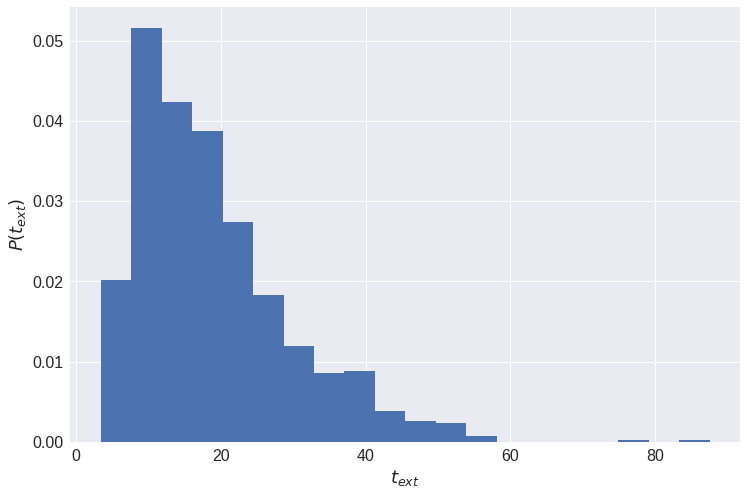

In [183]:
#@title 
#parámetros como los anteriores
omega = 100
b = 0.1
d = 0.3
b = b/omega
tf = 100
phi0 = 0.1
n = int (phi0*omega) #condicion inicial
ts_ext = [] #lista con los tiempos de extinción
real = 1000
fig = plt.figure(figsize=(12,8))
for i in range(real):
  x1,t1 = simulation_gillespie(2*b,d,omega,n,tf)
  if (x1[-1] <= 0):
    ts_ext.append(t1[-1])
plt.hist(ts_ext,density=True,bins=20)
plt.ylabel(r'$P(t_{ext})$',fontsize=18)
plt.xlabel(r'$t_{ext}$',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

## **Extinción de la especie por fluctuaciones**

Finalmente, podemos observar situaciones en las cuales la especie se extingue por fluctuaciones, aunque el comportamiento de la logística sea tal que, teóricamente, el sistema debería evolucionar hasta la capacidad de carga $K$. En particular, es esperable que esto suceda para poblaciones pequeñas. Por ejemplo, vamos a ilustrar un caso donde esto sucede, para $b = 0.1$ y $d = 0.1$, que son los parámetros utilizados previamente para estudiar una población con un estado estacionario positivo. Antes, utilizamos poblaciones de tamaño 100, mientras que ahora elegiremos $\Omega = 10$. Finalemente, la condición inicial es $\phi = 0.2$. Una realización de esta dinámica se observa en la próxima figura, donde se puede apreciar una extinción de la especie por fluctuaciones, mientras que la evolución logística es totalmente diferente. 

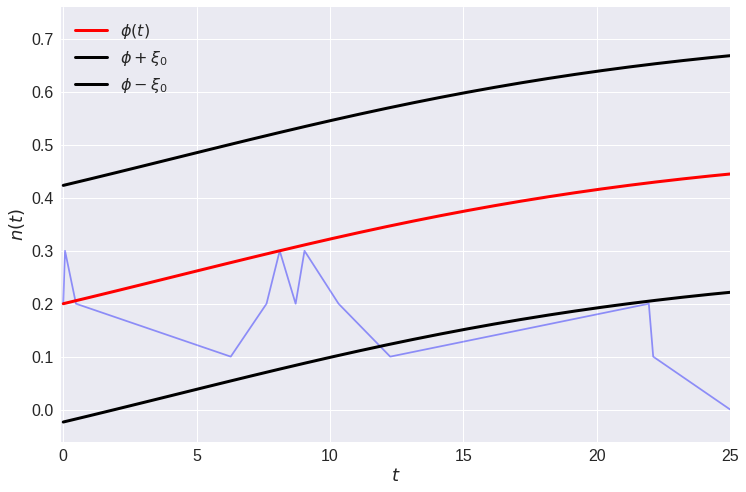

In [ ]:
#@title 
omega = 10
b = 0.1
d = 0.1
b = b/omega
tmax = 100
tf = 100
phi0 = 0.2
tlim_graf = 0
t = np.linspace(0,tmax,100)
phi,sig_asintotico = sol_exacta(t,b,d,omega,phi0)
n = int (phi0*omega) #condicion inicial
fig = plt.figure(figsize=(12,8))
for i in range(1):
  x1,t1 = simulation_gillespie(2*b,d,omega,n,tf)
  tlim_graf = max(tlim_graf,max(t1))
  plt.plot(t1,np.array(x1)/omega,color='b',alpha=0.4)
plt.plot(t,phi,'-r',label='$\phi (t)$',linewidth=3)
plt.plot(t,phi+np.array(sig_asintotico)/np.sqrt(omega),'-k',label=r'$\phi+\xi_{0}$',linewidth=3)
plt.plot(t,phi-np.array(sig_asintotico)/np.sqrt(omega),'-k',label=r'$\phi - \xi_{0}$',linewidth=3)
plt.legend(fontsize=16)
plt.ylabel(r'$n(t)$',fontsize=18)
plt.xlabel(r'$t$',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim((-0.1,tlim_graf))
plt.show()

Histograma del tiempo de extinción

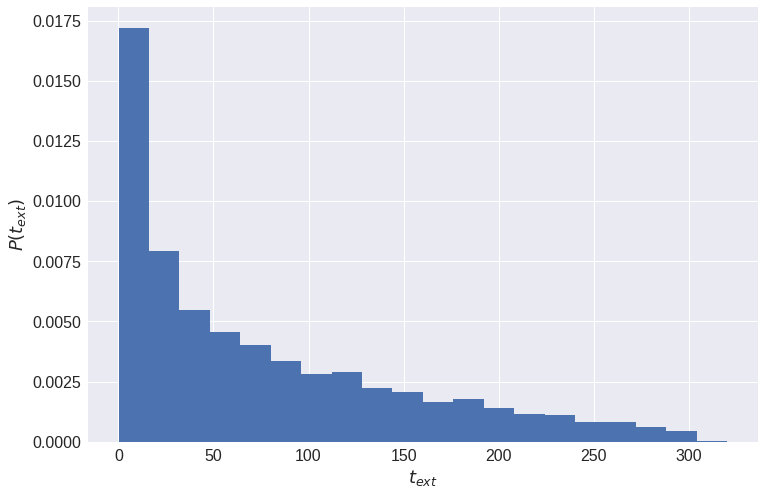

In [ ]:
#@title 
#parámetros como los anteriores
omega = 10
b = 0.1
d = 0.1
b = b/omega
tmax = 100
tf = 300
phi0 = 0.2
n = int (phi0*omega) #condicion inicial
ts_ext = [] #lista con los tiempos de extinción
real = 10000
fig = plt.figure(figsize=(12,8))
for i in range(real):
  x1,t1 = simulation_gillespie(2*b,d,omega,n,tf)
  if (x1[-1] <= 0):
    ts_ext.append(t1[-1])
plt.hist(ts_ext,density=True,bins=20)
plt.ylabel(r'$P(t_{ext})$',fontsize=18)
plt.xlabel(r'$t_{ext}$',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()